In [1]:
import itertools
import os
import random
import shutil
from os import listdir

import cv2
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.applications import \
    EfficientNetB0  # Example, can choose other EfficientNet versions
from tensorflow.keras.applications import EfficientNetB5, MobileNetV2
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau, TensorBoard)
from tensorflow.keras.layers import *
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D,
                                     Input)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  img_to_array)

In [ ]:
!nvidia-smi

Tue Nov 12 08:01:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   51C    P8              6W /   40W |     927MiB /   8188MiB |     21%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:30:42_Pacific_Standard_Time_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [ ]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for gpu in gpus:
        print("  -", gpu)
else:
    print("No GPUs detected.")

No GPUs detected.


In [ ]:
# Check available devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
    # Optionally, set memory growth to avoid TensorFlow using all GPU memory at once
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


In [ ]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def preprocess_image(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(256, 256))
    image = image_utils.img_to_array(image)
    image = image.reshape(1, 256, 256, 3)
    image = preprocess_input(image)
    return image

def classify_main_image(model, image):
    prediction = model.predict(image)
    main_classes = ['Healthy', 'Diseased']
    main_class_index = np.argmax(prediction)
    return main_class_index, main_classes[main_class_index]


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
# Confusion matrix labels
cm_plot_labels = ['Healthy', 'Diseased']

In [ ]:
# Basic variables definition
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
depth = 3
IMG_SIZE = 256
NUM_CLASSES = 2

In [ ]:
def split_dataset_with_health_status(original_dataset_dir, output_base_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Splits the original dataset into train, validation, and test sets based on the provided ratios,
    categorizing images into 'Healthy' and 'Diseased' groups.

    Parameters:
    - original_dataset_dir (str): Path to the original dataset directory.
    - output_base_dir (str): Path to the output directory where train, val, and test directories will be created.
    - train_ratio (float): Ratio of images to be used for training.
    - val_ratio (float): Ratio of images to be used for validation.
    - test_ratio (float): Ratio of images to be used for testing.
    - seed (int): Random seed for reproducibility.
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Train, val, and test ratios must sum to 1."

    # Set random seed for reproducibility
    random.seed(seed)

    # Creating output directories for train, val, and test
    train_dir = os.path.join(output_base_dir, 'train')
    val_dir = os.path.join(output_base_dir, 'val')
    test_dir = os.path.join(output_base_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    diseased_folders = ['Damaged', 'EarlyStage', 'LateStage', 'Old_Dead']  # Define diseased subclasses
    healthy_folder = 'Healthy'  # Define healthy folder

    # Handling Healthy class
    healthy_path = os.path.join(original_dataset_dir, healthy_folder)
    if os.path.isdir(healthy_path):
        os.makedirs(os.path.join(train_dir, 'Healthy'), exist_ok=True)
        os.makedirs(os.path.join(val_dir, 'Healthy'), exist_ok=True)
        os.makedirs(os.path.join(test_dir, 'Healthy'), exist_ok=True)
        
        # Listing and shuffling images
        healthy_images = [img for img in os.listdir(healthy_path) if os.path.isfile(os.path.join(healthy_path, img))]
        random.shuffle(healthy_images)
        
        # Splitting the images
        train_end = int(len(healthy_images) * train_ratio)
        val_end = train_end + int(len(healthy_images) * val_ratio)

        train_images = healthy_images[:train_end]
        val_images = healthy_images[train_end:val_end]
        test_images = healthy_images[val_end:]

        # Copying images to respective directories
        for img in train_images:
            shutil.copy(os.path.join(healthy_path, img), os.path.join(train_dir, 'Healthy', img))
        for img in val_images:
            shutil.copy(os.path.join(healthy_path, img), os.path.join(val_dir, 'Healthy', img))
        for img in test_images:
            shutil.copy(os.path.join(healthy_path, img), os.path.join(test_dir, 'Healthy', img))

    # Handling Diseased class by grouping all diseased subclasses together
    os.makedirs(os.path.join(train_dir, 'Diseased'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'Diseased'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'Diseased'), exist_ok=True)

    for diseased_subfolder in diseased_folders:
        diseased_path = os.path.join(original_dataset_dir, diseased_subfolder)
        if os.path.isdir(diseased_path):
            # Listing and shuffling images
            diseased_images = [img for img in os.listdir(diseased_path) if os.path.isfile(os.path.join(diseased_path, img))]
            random.shuffle(diseased_images)
            
            # Splitting the images
            train_end = int(len(diseased_images) * train_ratio)
            val_end = train_end + int(len(diseased_images) * val_ratio)

            train_images = diseased_images[:train_end]
            val_images = diseased_images[train_end:val_end]
            test_images = diseased_images[val_end:]

            # Copying images to respective directories under 'Diseased'
            for img in train_images:
                shutil.copy(os.path.join(diseased_path, img), os.path.join(train_dir, 'Diseased', img))
            for img in val_images:
                shutil.copy(os.path.join(diseased_path, img), os.path.join(val_dir, 'Diseased', img))
            for img in test_images:
                shutil.copy(os.path.join(diseased_path, img), os.path.join(test_dir, 'Diseased', img))

    print(f"Dataset split into train ({train_ratio*100}%), val ({val_ratio*100}%), and test ({test_ratio*100}%) sets.")

In [ ]:
# Example usage
original_dataset_dir = 'Datasets/DBX/Cactus'  # Replace with the path to your original dataset
output_base_dir = 'DatasetPreped'  # Replace with the path to output train/val/test folders

split_dataset_with_health_status(original_dataset_dir, output_base_dir)


Dataset split into train (70.0%), val (15.0%), and test (15.0%) sets.


In [ ]:
# Paths of train, validation, and test directories of the first dataset
train_dir = "DatasetPreped/train"
val_dir = "DatasetPreped/val"
test_dir = "DatasetPreped/test"
OUTPUT_DIR = 'ModelTraining'  # Directory to save models
OUTPUT_DIR2 = 'ModelTraining2' 
os.makedirs(OUTPUT_DIR, exist_ok=True) 
os.makedirs(OUTPUT_DIR2, exist_ok=True)

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    label_mode="categorical", 
    image_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BS, 
    seed=42, 
    shuffle=True
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, 
    label_mode="categorical", 
    image_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BS, 
    seed=42, 
    shuffle=False
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    label_mode="categorical", 
    image_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BS, 
    seed=42, 
    shuffle=False
)


Found 2275 files belonging to 2 classes.
Found 486 files belonging to 2 classes.
Found 491 files belonging to 2 classes.


In [ ]:
# Load pre-trained MobileNetV2 without the top layer
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze the base model

C:\Users\khali\AppData\Local\Temp\ipykernel_24628\2590158324.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step


In [ ]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # 2 classes for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Define a custom model checkpoint callback
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, output_dir):
        super(CustomModelCheckpoint, self).__init__()
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss', 0.0)
        acc = logs.get('val_accuracy', 0.0)
        filename = os.path.join(
            self.output_dir,
            f"model_epoch_{epoch+1:02d}_val_loss_{loss:.4f}_val_acc_{acc:.4f}.keras"
        )
        self.model.save(filename)
        print(f"Model saved: {filename}")


In [ ]:
# Define callbacks
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
)

In [ ]:
# Train the model with callbacks
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[stop_early, reduce_lr, CustomModelCheckpoint(output_dir=OUTPUT_DIR)]
)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9600 - loss: 0.1991

Model saved: ModelTraining\model_epoch_01_val_loss_0.1528_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.9600 - loss: 0.1991 - val_accuracy: 0.9630 - val_loss: 0.1528 - learning_rate: 0.0010
Epoch 2/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9667 - loss: 0.1464

Model saved: ModelTraining\model_epoch_02_val_loss_0.1453_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.9666 - loss: 0.1468 - val_accuracy: 0.9630 - val_loss: 0.1453 - learning_rate: 0.0010
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9654 - loss: 0.1436

Model saved: ModelTraining\model_epoch_03_val_loss_0.1470_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.9654 - loss: 0.1439 - val_accuracy: 0.9630 - val_loss: 0.1470 - learning_rate: 0.0010
Epoch 4/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9659 - loss: 0.1407

Model saved: ModelTraining\model_epoch_04_val_loss_0.1332_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.9658 - loss: 0.1410 - val_accuracy: 0.9630 - val_loss: 0.1332 - learning_rate: 0.0010
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9666 - loss: 0.1360

Model saved: ModelTraining\model_epoch_05_val_loss_0.1337_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 263ms/step - accuracy: 0.9666 - loss: 0.1363 - val_accuracy: 0.9630 - val_loss: 0.1337 - learning_rate: 0.0010
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9667 - loss: 0.1315

Model saved: ModelTraining\model_epoch_06_val_loss_0.1317_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - accuracy: 0.9667 - loss: 0.1318 - val_accuracy: 0.9630 - val_loss: 0.1317 - learning_rate: 0.0010
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9697 - loss: 0.1226

Model saved: ModelTraining\model_epoch_07_val_loss_0.1347_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.9696 - loss: 0.1230 - val_accuracy: 0.9630 - val_loss: 0.1347 - learning_rate: 0.0010
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9651 - loss: 0.1347

Model saved: ModelTraining\model_epoch_08_val_loss_0.1345_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.9650 - loss: 0.1350 - val_accuracy: 0.9630 - val_loss: 0.1345 - learning_rate: 0.0010
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9677 - loss: 0.1190
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


Model saved: ModelTraining\model_epoch_09_val_loss_0.1345_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.9676 - loss: 0.1193 - val_accuracy: 0.9630 - val_loss: 0.1345 - learning_rate: 0.0010
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9672 - loss: 0.1143

Model saved: ModelTraining\model_epoch_10_val_loss_0.1307_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.9671 - loss: 0.1145 - val_accuracy: 0.9630 - val_loss: 0.1307 - learning_rate: 5.0000e-04
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9689 - loss: 0.1101

Model saved: ModelTraining\model_epoch_11_val_loss_0.1313_val_acc_0.9609.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 271ms/step - accuracy: 0.9688 - loss: 0.1104 - val_accuracy: 0.9609 - val_loss: 0.1313 - learning_rate: 5.0000e-04
Epoch 12/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9688 - loss: 0.1118

Model saved: ModelTraining\model_epoch_12_val_loss_0.1288_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.9686 - loss: 0.1123 - val_accuracy: 0.9630 - val_loss: 0.1288 - learning_rate: 5.0000e-04
Epoch 13/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9673 - loss: 0.1133

Model saved: ModelTraining\model_epoch_13_val_loss_0.1308_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - accuracy: 0.9672 - loss: 0.1138 - val_accuracy: 0.9630 - val_loss: 0.1308 - learning_rate: 5.0000e-04
Epoch 14/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9701 - loss: 0.1060

Model saved: ModelTraining\model_epoch_14_val_loss_0.1298_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.9699 - loss: 0.1065 - val_accuracy: 0.9630 - val_loss: 0.1298 - learning_rate: 5.0000e-04
Epoch 15/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9719 - loss: 0.1055
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


Model saved: ModelTraining\model_epoch_15_val_loss_0.1307_val_acc_0.9650.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.9716 - loss: 0.1061 - val_accuracy: 0.9650 - val_loss: 0.1307 - learning_rate: 5.0000e-04
Epoch 16/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9700 - loss: 0.1029

Model saved: ModelTraining\model_epoch_16_val_loss_0.1296_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.9698 - loss: 0.1035 - val_accuracy: 0.9630 - val_loss: 0.1296 - learning_rate: 2.5000e-04
Epoch 17/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9697 - loss: 0.1003

Model saved: ModelTraining\model_epoch_17_val_loss_0.1300_val_acc_0.9630.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.9696 - loss: 0.1006 - val_accuracy: 0.9630 - val_loss: 0.1300 - learning_rate: 2.5000e-04


In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Predict the labels for the test dataset
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true_classes = np.argmax(y_true, axis=1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.9945 - loss: 0.0622
Test accuracy: 96.13%
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step


Confusion Matrix:
 [[472   0]
 [ 19   0]]


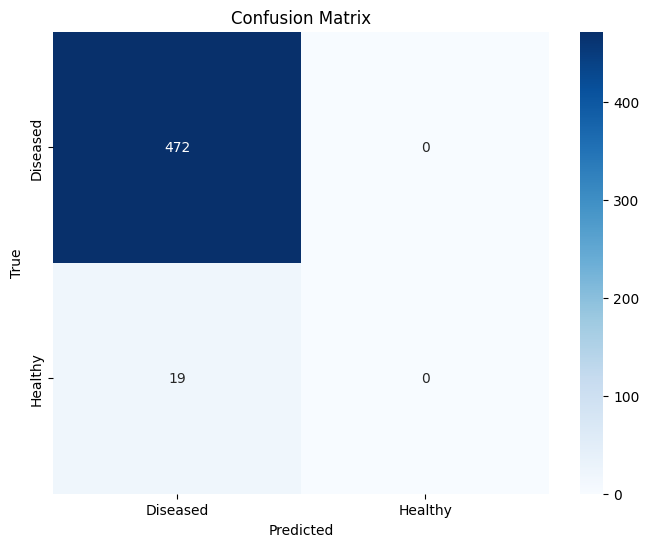

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_names, yticklabels=test_data.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Optional: Display a classification report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=test_data.class_names))


Classification Report:
               precision    recall  f1-score   support

    Diseased       0.96      1.00      0.98       472
     Healthy       0.00      0.00      0.00        19

    accuracy                           0.96       491
   macro avg       0.48      0.50      0.49       491
weighted avg       0.92      0.96      0.94       491



c:\Users\khali\OneDrive\Bureau\amine\CactiViT-materials-master\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khali\OneDrive\Bureau\amine\CactiViT-materials-master\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khali\OneDrive\Bureau\amine\CactiViT-materials-master\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [ ]:
# Data augmentation layer for robustness
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),  # Randomly changes brightness
    tf.keras.layers.RandomTranslation(0.1, 0.1),  # Translate images slightly
])

In [ ]:
# Load pre-trained MobileNetV2 without the top layer
second_base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

second_base_model.trainable = False  # Freeze the base model

# Build the model with data augmentation
second_model = Sequential([
    data_augmentation,  # Apply data augmentation here
    second_base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # 2 classes for binary classification
])

# Compile the model
second_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



C:\Users\khali\AppData\Local\Temp\ipykernel_24628\2494182727.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  second_base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),


In [ ]:
# Fine-tune the model with callbacks
fine_tune_history = second_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[stop_early, reduce_lr, CustomModelCheckpoint(output_dir=OUTPUT_DIR2)]
)

Epoch 1/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9638 - loss: 0.1613Model saved: ModelTraining2\model_epoch_01_val_loss_0.1482_val_acc_0.9630.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step - accuracy: 0.9637 - loss: 0.1615 - val_accuracy: 0.9630 - val_loss: 0.1482 - learning_rate: 0.0010
Epoch 2/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9641 - loss: 0.1573Model saved: ModelTraining2\model_epoch_02_val_loss_0.1551_val_acc_0.9630.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.9641 - loss: 0.1575 - val_accuracy: 0.9630 - val_loss: 0.1551 - learning_rate: 0.0010
Epoch 3/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9665 - loss: 0.1463Model saved: ModelTraining2\model_epoch_03_val_loss_0.1750_val_acc_0.9630.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 209ms/step - accuracy: 0.9664 - loss: 0.1468 - val_accuracy: 0.9630 - val_loss: 0.1750 - learning_rate: 0.0010
Epoch 4/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9653 - loss: 

In [ ]:
# Evaluate the model on the test data
loss2, accuracy2 = second_model.evaluate(test_data)
print(f"Test accuracy: {accuracy2 * 100:.2f}%")

# Predict the labels for the test dataset
y_pred2 = second_model.predict(test_data)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Extract true labels
y_true2 = np.concatenate([y for x, y in test_data], axis=0)
y_true_classes2 = np.argmax(y_true2, axis=1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9945 - loss: 0.0549
Test accuracy: 96.13%
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step


Confusion Matrix:
 [[472   0]
 [ 19   0]]


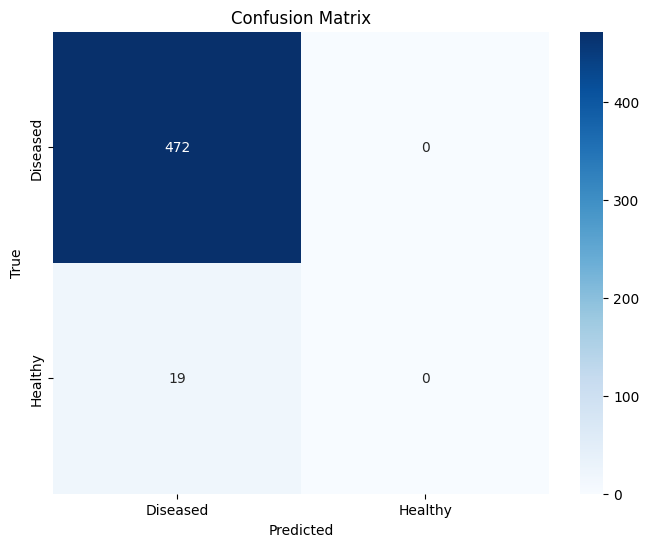

In [ ]:
# Generate confusion matrix
conf_matrix2 = confusion_matrix(y_true_classes2, y_pred_classes2)
print("Confusion Matrix:\n", conf_matrix2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_names, yticklabels=test_data.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Optional: Display a classification report
print("Classification Report:\n", classification_report(y_true_classes2, y_pred_classes2, target_names=test_data.class_names))


Classification Report:
               precision    recall  f1-score   support

    Diseased       0.96      1.00      0.98       472
     Healthy       0.00      0.00      0.00        19

    accuracy                           0.96       491
   macro avg       0.48      0.50      0.49       491
weighted avg       0.92      0.96      0.94       491



c:\Users\khali\OneDrive\Bureau\amine\CactiViT-materials-master\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khali\OneDrive\Bureau\amine\CactiViT-materials-master\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khali\OneDrive\Bureau\amine\CactiViT-materials-master\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont